In [5]:
%load_ext autoreload
%autoreload 2

In [6]:
from google.colab import drive
drive.mount('/content/drive')
import tensorflow as tf
tf.test.gpu_device_name()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
!pip install -q keras

'/device:GPU:0'

In [9]:
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten, Activation, MaxPooling2D

class ConvNet:
    def __init__(self, numFilters, filterSize, filterConf = 'same'):
        return

    def initModel(self, numFilters, filterSize, filterConf = 'same'):
        model = Sequential()
        input_shape1 = (256, 256, 3)
        model.add(Conv2D(numFilters, (filterSize, filterSize), input_shape=input_shape1))
        model.add(Activation('relu'))
        model.add(MaxPooling2D(pool_size=(2, 2)))        
        
        for l in range(4):
            model.add(Conv2D(numFilters, (filterSize, filterSize)))
            model.add(Activation('relu'))
            model.add(MaxPooling2D(pool_size=(2, 2)))
        
        model.add(Flatten())
        #model.add(Dense(128, activation='relu'))
        model.add(Dense(10, activation='softmax'))
        
        return model

In [14]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import array_to_img
import cv2
import csv

DATSET_SIZE = 2000

labels = ["Amphibia","Animalia","Arachnida","Aves","Fungi","Insecta","Mammalia","Mollusca","Plantae","Reptilia"]
Dataset_Path = '/content/drive/MyDrive/inaturalist_12K'
train_path = os.path.join(Dataset_Path , 'train')
test_path = os.path.join(Dataset_Path , 'val')
def loadImages():
    trainfiles = []
    trainclasses = []
    classcounts = [0 for i in range(10)]
    testfiles = []
    testclasses = []
    for subdir , dirs , files in os.walk(train_path):
        for file in files:
            if file.endswith(".jpg"):
                trainfiles.append(os.path.join(subdir,file))
                c = str(subdir).split(os.sep)[-1]
                for i in range(10):
                    if labels[i] == c:
                        trainclasses.append(i)
                        classcounts[i]+=1
                        break
    for subdir , dirs , files in os.walk(train_path):
        for file in files:
            if file.endswith(".jpg"):
                testfiles.append(os.path.join(subdir,file))
                c = str(subdir).split(os.sep)[-1]
                for i in range(10):
                    if labels[i] == c:
                        testclasses.append(i)
    return trainfiles , trainclasses , testfiles , testclasses , classcounts
def preprocess(data, height, width):
    dim = (width, height)
    resdata = []
    for i in range(len(data[:DATSET_SIZE])):
        try:
            img = cv2.imread(data[i],cv2.IMREAD_UNCHANGED)
            res = cv2.resize(img, dim , interpolation=cv2.INTER_LINEAR)
            #if image is greyscale, convert it to rgb
            if(len(res.shape) != 3):
                res = cv2.cvtColor(res,cv2.COLOR_GRAY2RGB)
            resdata.append(np.asarray(res))
        except Exception as e:
            print(data[i])
            print(str(e))
    return resdata

def dataset(width,height):
    trainfiles , trainclasses , testfiles , testclasses, classcounts = loadImages()
    train_data = preprocess(trainfiles, height,width)
    test_data = preprocess(testfiles, height,width)
    # train_input = []
    # val_input = []
    # train_output = []
    # val_output = []
    # test_output = []
    # test_input = []
    train_output = np.eye(10)[trainclasses]
    test_output = np.eye(10)[testclasses]
    
    L = len(train_data)
    return {
        'Xtrain' : np.array(train_data), 
        'Ytrain' : np.array(train_output),
        # 'Xval' : np.array(val_input),
        # 'Yval' : np.array(val_output),
        'Xtest' :np.array(test_data),
        'Ytest' :np.array(test_output)
    }
def flat(X):
    X_f = []
    for x in X:
        X_f.append(x.flatten())
    return X_f
def savedata(d): 
    with open('train_data.txt','w') as f:
        csvwriter = csv.writer(f)
        csvwriter.writerows(flat(d['Xtrain']))
# d = dataset(256,256)
# print(d['Xtrain'])
    


In [11]:
# dataset(256,256)

In [12]:
network = ConvNet(32, 3)
model = network.initModel(32, 3)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 254, 254, 32)      896       
_________________________________________________________________
activation (Activation)      (None, 254, 254, 32)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 127, 127, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 125, 125, 32)      9248      
_________________________________________________________________
activation_1 (Activation)    (None, 125, 125, 32)      0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 62, 62, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 60, 60, 32)        9

In [15]:
ds = dataset(256, 256)
train_images = ds['Xtrain']
train_labels = ds['Ytrain']

In [ ]:
import numpy as np

In [21]:
print(train_images)

[[[[181 197 193]
   [165 194 168]
   [120 163 137]
   ...
   [154 187 167]
   [132 170 145]
   [166 191 172]]

  [[150 184 172]
   [151 196 176]
   [153 183 167]
   ...
   [163 192 168]
   [145 179 150]
   [129 161 134]]

  [[149 185 164]
   [150 190 161]
   [142 182 152]
   ...
   [148 178 149]
   [143 186 154]
   [157 184 165]]

  ...

  [[187 194 207]
   [117 153 123]
   [128 160 128]
   ...
   [ 69 115 100]
   [ 98 143 122]
   [ 51 117  95]]

  [[116 120 123]
   [131 159 121]
   [150 181 150]
   ...
   [ 47  76  80]
   [ 31  91  74]
   [ 32  87  62]]

  [[152 183 144]
   [139 174 134]
   [156 201 159]
   ...
   [ 90 130 112]
   [ 62 107  86]
   [ 45  94  73]]]


 [[[ 30  37  35]
   [ 37  53  57]
   [ 67  93 111]
   ...
   [ 67  83  97]
   [ 96 114 131]
   [103 114 126]]

  [[ 19  24  25]
   [ 13  22  20]
   [ 26  38  36]
   ...
   [ 82  88 103]
   [ 98 120 137]
   [101 113 131]]

  [[ 15  22  18]
   [ 10  20  18]
   [ 24  35  33]
   ...
   [ 66  58  63]
   [ 76  68  77]
   [ 70  72

In [23]:
train_images = train_images/255.0


(2000, 10)


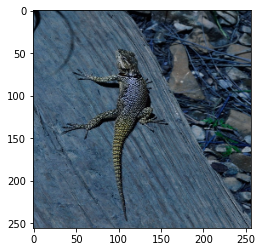

In [31]:
plt.imshow(train_images[1000])


In [27]:
model.compile(loss='categorical_crossentropy',
              optimizer='sgd',
              metrics=['accuracy'])

model.fit(train_images, train_labels[:2000],
          batch_size=128,
          epochs=5,
          validation_split=0.1,
          verbose=1)

Epoch 1/5
15/15 [==============================] - 3s 180ms/step - loss: nan - accuracy: 0.0000e+00 - val_loss: nan - val_accuracy: 0.0000e+00
Epoch 2/5
15/15 [==============================] - 2s 163ms/step - loss: nan - accuracy: 0.0000e+00 - val_loss: nan - val_accuracy: 0.0000e+00
Epoch 3/5
15/15 [==============================] - 2s 166ms/step - loss: nan - accuracy: 0.0000e+00 - val_loss: nan - val_accuracy: 0.0000e+00
Epoch 4/5
15/15 [==============================] - 2s 163ms/step - loss: nan - accuracy: 0.0000e+00 - val_loss: nan - val_accuracy: 0.0000e+00
Epoch 5/5
15/15 [==============================] - 2s 164ms/step - loss: nan - accuracy: 0.0000e+00 - val_loss: nan - val_accuracy: 0.0000e+00


In [ ]:
print(len(train_images))

12


In [ ]:
# print(len(train_images))
# model.summary()
print(train_images)

[[[[ 73  87  86]
   [ 72  85  87]
   [ 77  89  93]
   ...
   [ 81  77  77]
   [ 79  76  78]
   [ 87  84  93]]

  [[ 79  91  93]
   [ 71  84  86]
   [ 75  87  91]
   ...
   [ 80  78  78]
   [ 79  77  79]
   [ 85  84  93]]

  [[ 76  86  91]
   [ 74  84  90]
   [ 94 106 110]
   ...
   [ 97  95  94]
   [ 85  86  87]
   [ 83  85  92]]

  ...

  [[ 31  42  40]
   [ 28  34  31]
   [ 20  31  28]
   ...
   [ 38  45  41]
   [ 23  28  29]
   [ 19  27  22]]

  [[ 33  44  42]
   [ 36  41  39]
   [ 43  55  50]
   ...
   [ 28  33  32]
   [ 23  28  32]
   [ 25  32  29]]

  [[ 25  35  36]
   [ 39  45  43]
   [ 48  60  54]
   ...
   [ 17  21  22]
   [ 17  21  26]
   [ 19  25  25]]]


 [[[131 127 117]
   [125 124 114]
   [154 150 136]
   ...
   [189 178 176]
   [173 165 164]
   [179 178 175]]

  [[ 94  95  86]
   [ 91  96  88]
   [103 104  94]
   ...
   [159 165 164]
   [122 137 135]
   [144 147 148]]

  [[112 103  93]
   [110 108  98]
   [135 134 121]
   ...
   [178 173 174]
   [154 162 162]
   [157 168